In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import os
import sys; sys.path.append('/home/marcush/projects/neural_control/analysis_scripts/turnkey')

from config import PATH_DICT; sys.path.append(PATH_DICT['repo'])
from region_select import *
from utils import calc_loadings
from collections import defaultdict
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [5]:
path = '/clusterfs/NSDS_data/FCCA/postprocessed/decoding_fullarg_frank_lab_glom.pickle'
with open(path, 'rb') as f:
    data = pickle.load(f)

df_decode = pd.DataFrame(data)

In [6]:
dimensions = np.unique(df_decode['dim'])
n_folds = np.unique(df_decode['fold_idx'])
dimreduc_methods = np.unique(df_decode['dimreduc_method'])
proj_methods = np.append(dimreduc_methods, 'CCA')
regions = np.unique(df_decode['loader_args'].apply(lambda x: x.get('region')))

### Load consolidated decoding dataframe

In [7]:
bin_width = [10, 25, 50, 100]
trialize = [True, False]
spike_threshold = [0, 100]
regions_lArgs = ['mPFC', 'HPC'] # this may not be in the same order as regions default from the df_decode
loader_combs = itertools.product(bin_width, trialize, spike_threshold, regions_lArgs)
loader_args = []
for lArgs in loader_combs:
    bWidth, bTrialize, spike_thresh, reg = lArgs
    if bTrialize:
        loader_args.append({'bin_width':bWidth, 'region':reg, 'spike_threshold':spike_thresh,  'speed_threshold':False, 'trialize':bTrialize})
    else:
        loader_args.append({'bin_width':bWidth, 'region':reg, 'spike_threshold':spike_thresh, 'speed_threshold':False, 'trialize':bTrialize})
        loader_args.append({'bin_width':bWidth, 'region':reg, 'spike_threshold':spike_thresh, 'speed_threshold':True, 'trialize':bTrialize})

dimreduc_args = []
for T in np.array([1, 3, 5]):
    dimreduc_args.append({'T':T, 'loss_type':'trace', 'n_init':10})

decoders = [{'trainlag': 0, 'testlag': 0, 'decoding_window': 6},
            {'trainlag': 1, 'testlag': 1, 'decoding_window': 6},
            {'trainlag': -1, 'testlag': -1, 'decoding_window': 6},
            {'trainlag': 2, 'testlag': 2, 'decoding_window': 6},
            {'trainlag': -2, 'testlag': -2, 'decoding_window': 4}]

In [8]:
# --------- To see all the parameters analyzed ---------
#dictionary = loader_args #dimreduc_args, decoders
#for i, dictionary in enumerate(dictionary):
#    print(f"Idx {i}: {dictionary}")

bin_width = 25 # [10, 25, 50, 100]
spike_threshold = 0 # [0, 100]
speed_threshold = False
trialize = False


loader_args_query_reg0 = {'bin_width': bin_width, 'region': regions[0], 'spike_threshold': spike_threshold, 'speed_threshold':speed_threshold, 'trialize':trialize}
loader_args_query_idx_reg0 = [i for i, dictionary in enumerate(loader_args)  if all(dictionary.get(key) == value for key, value in loader_args_query_reg0.items())][0]
print(f"Loader Args Idx (Region 0): {loader_args_query_idx_reg0}")


loader_args_query_reg1 = {'bin_width': bin_width, 'region': regions[1], 'spike_threshold': spike_threshold, 'speed_threshold':speed_threshold, 'trialize':trialize}
loader_args_query_idx_reg1 = [i for i, dictionary in enumerate(loader_args)  if all(dictionary.get(key) == value for key, value in loader_args_query_reg1.items())][0]
print(f"Loader Args Idx (Region 1): {loader_args_query_idx_reg1}")


dimreduc_args_query = {'T': 3, 'loss_type': 'trace', 'n_init': 10}
dimreduc_args_query_idx = [i for i, dictionary in enumerate(dimreduc_args)  if all(dictionary.get(key) == value for key, value in dimreduc_args_query.items())][0]
print(f"Dimreduc Args Idx: {dimreduc_args_query_idx}")



decoders_args_query = {'trainlag': 1, 'testlag': 1, 'decoding_window': 6}
decoders_args_query_idx = [i for i, dictionary in enumerate(decoders)  if all(dictionary.get(key) == value for key, value in decoders_args_query.items())][0]
print(f"Decoding Args Idx: {decoders_args_query_idx}")



Loader Args Idx: 18
Loader Args Idx: 16
Dimreduc Args Idx: 1
Decoding Args Idx: 1


### For some reason these three lines need to be in seperate cells or the kernel will crash:

In [6]:
df_decode_reg0, _ = load_decoding_df(regions[0], **{'load_idx':loader_args_query_idx_reg0, 'dec_idx':decoders_args_query_idx, 'dr_idx':dimreduc_args_query_idx})

In [7]:
df_decode_reg1, _ = load_decoding_df(regions[1], **{'load_idx':loader_args_query_idx_reg1, 'dec_idx':decoders_args_query_idx, 'dr_idx':dimreduc_args_query_idx})

In [8]:
df_decode = pd.concat([df_decode_reg0, df_decode_reg1])

### Load the processed data from both regions

In [9]:
dat = load_franklab_new(get_data_path(regions[0]), **loader_args_query_reg0)
reg0_spikes = dat['spike_rates']


dat = load_franklab_new(get_data_path(regions[1]), **loader_args_query_reg1)
reg1_spikes = dat['spike_rates']

all_spikes = {regions[0]: reg0_spikes, regions[1]: reg1_spikes}

FILTERING SPIKE RATES!
FILTERING SPIKE RATES!


### Load CCA model

In [17]:
manual_dimension = 20

In [18]:
ccamodel_path = f'/home/marcush/projects/neural_control/analysis_scripts/FrankLabAnalysis/CCA_Results/CCA_{manual_dimension}_dims.pkl'
with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

# Using ideal dimension for across region comparison

In [19]:
DIM = manual_dimension

all_comparisons_0_1 = []
all_comparisons_1_0 = []
proj_correlations = {}

combo_ind = 0
region_method_pairs = set()  # Set to keep track of seen combinations
for region0, region1, method0, method1 in itertools.product(regions, regions, proj_methods, proj_methods):
    sorted_0 = tuple(sorted([region0, method0]))
    sorted_1 = tuple(sorted([region1, method1]))
    
    combo = (tuple(sorted((sorted_0, sorted_1))))
    
    if combo in region_method_pairs:
        continue  
    elif region0 == region1 and method0 == method1:
        continue
    region_method_pairs.add(combo)
    

    n_fold_r2_0_1 = np.zeros(len(n_folds))
    n_fold_r2_1_0 = np.zeros(len(n_folds))
    avg_correlations = np.zeros(len(n_folds))
    
    
    for n_fold in n_folds:

        if method0 == 'CCA' and method1 == 'CCA':
            if region0 == regions[0]:
                ProjMat0 = ccamodel.x_rotations_
                ProjMat1 = ccamodel.y_rotations_
            elif region0 == regions[1]:
                ProjMat0 = ccamodel.y_rotations_
                ProjMat1 = ccamodel.x_rotations_

        elif method0 == 'CCA':
            #ProjMat1 = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_decode['dim'] == DIM) & (df_decode['fold_idx'] == n_fold) & (df_decode['dimreduc_method'] == method1)]['coef'].iloc[0]                        
            ProjMat1 =  apply_df_filters(df_decode, **{'fold_idx':n_fold, 'dim':DIM, 'dimreduc_method':method1, 'loader_args':{'region':region1}})['coef'].iloc[0]


            if region0 == regions[0]:
                ProjMat0 = ccamodel.x_rotations_
            elif region0 == regions[1]:
                ProjMat0 = ccamodel.y_rotations_

        elif method1 == 'CCA':
            #ProjMat0 = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_decode['dim'] == DIM) & (df_decode['fold_idx'] == n_fold) & (df_decode['dimreduc_method'] == method0)]['coef'].iloc[0]
            ProjMat0 =  apply_df_filters(df_decode, **{'fold_idx':n_fold, 'dim':DIM, 'dimreduc_method':method0, 'loader_args':{'region':region0}})['coef'].iloc[0]
            if region1 == regions[0]:
                ProjMat1 = ccamodel.x_rotations_
            elif region1 == regions[1]:
                ProjMat1 = ccamodel.y_rotations_
        else:
            #ProjMat0 = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_decode['dim'] == DIM) & (df_decode['fold_idx'] == n_fold) & (df_decode['dimreduc_method'] == method0)]['coef'].iloc[0]
            #ProjMat1 = df_decode[(df_decode['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_decode['dim'] == DIM) & (df_decode['fold_idx'] == n_fold) & (df_decode['dimreduc_method'] == method1)]['coef'].iloc[0]

            ProjMat0 =  apply_df_filters(df_decode, **{'fold_idx':n_fold, 'dim':DIM, 'dimreduc_method':method0, 'loader_args':{'region':region0}})['coef'].iloc[0]
            ProjMat1 =  apply_df_filters(df_decode, **{'fold_idx':n_fold, 'dim':DIM, 'dimreduc_method':method1, 'loader_args':{'region':region1}})['coef'].iloc[0]


        projData0 = all_spikes[region0] @ ProjMat0[:,0:DIM]
        projData1 = all_spikes[region1] @ ProjMat1[:,0:DIM]


        model_0_1 = LinearRegression()
        model_0_1.fit(projData0, projData1)
        r2_0_1 = model_0_1.score(projData0, projData1)
        
        model_1_0 = LinearRegression()
        model_1_0.fit(projData1, projData0)
        r2_1_0 = model_1_0.score(projData1, projData0)

        correlations = []
        for row_x, row_y in zip(projData0, projData1):
            corr, _ = pearsonr(row_x, row_y)
            correlations.append(corr)
        average_correlation = np.mean(correlations)


        avg_correlations[n_fold] = average_correlation
        n_fold_r2_0_1[n_fold] = r2_0_1
        n_fold_r2_1_0[n_fold] = r2_1_0

        
    R2_avg_0_1 = np.mean(n_fold_r2_0_1)
    R2_avg_1_0 = np.mean(n_fold_r2_1_0)

    all_comparisons_0_1.append(R2_avg_0_1)
    all_comparisons_1_0.append(R2_avg_1_0)

    #models[f"{region0}_{method0}_{region1}_{method1}"] = model_0_1
    proj_correlations[f"{region0}_{method0}_{region1}_{method1}"] = np.mean(avg_correlations)
        
    combo_ind += 1

In [1]:
unique_groups = [(regions[0], 'CCA'), (regions[0], 'LQGCA'), (regions[0], 'PCA'), (regions[1], 'CCA'), (regions[1], 'LQGCA'), (regions[1], 'PCA')]
unique_group_labels = [(regions[0], 'CCA'), (regions[0], 'FBC'), (regions[0], 'FFC'), (regions[1], 'CCA'), (regions[1], 'FBC'), (regions[1], 'FFC')]

group_indices = {group: i for i, group in enumerate(unique_groups)}

n = 6  # We have 6 unique groups
matrix = np.zeros((n, n))  # Initialize the matrix with zeros

correlation_index = 0
for i in range(n):
    for j in range(i + 1, n):
        matrix[i, j] = all_comparisons_0_1[correlation_index]
        matrix[j, i] = all_comparisons_1_0[correlation_index]  # Not Symmetric
        correlation_index += 1

# Set diagonal values to NaN
np.fill_diagonal(matrix, np.nan)

labels = [f"{reg}, {meth}" for reg, meth in unique_group_labels]

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap='coolwarm')
plt.colorbar(cax)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=45, ha="left", rotation_mode="anchor")
ax.set_yticklabels(labels)

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(matrix):
    if not np.isnan(val):  # Skip NaN values
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

midpoint = n / 2
ax.axhline(midpoint - 0.5, color='black', linewidth=0.5)  # Horizontal line
ax.axvline(midpoint - 0.5, color='black', linewidth=0.5)  # Vertical line

plt.title(f'R² value between projected activity')
plt.xlabel('region, subspace')
plt.ylabel('region, subspace')
plt.show()

fig.savefig('/home/marcush/projects/neural_control/analysis_scripts/FrankLabAnalysis/activity_regression.pdf')


NameError: name 'regions' is not defined

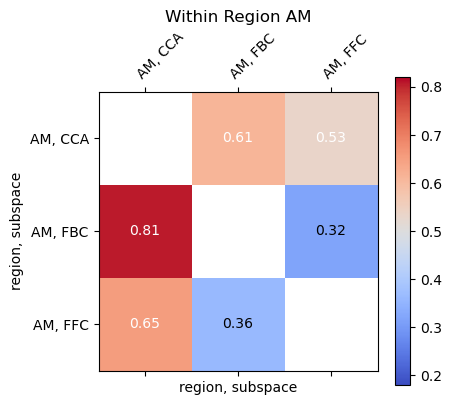

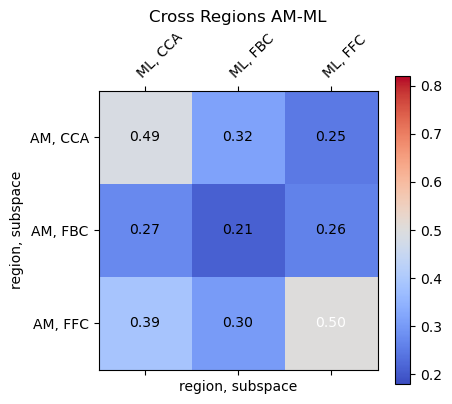

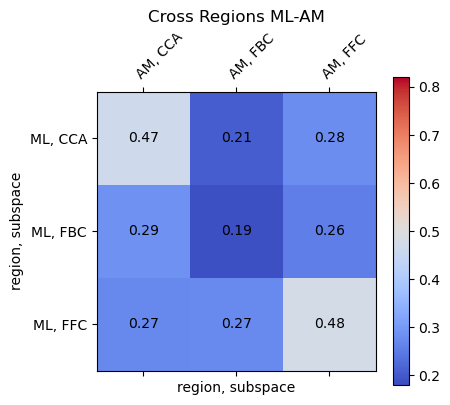

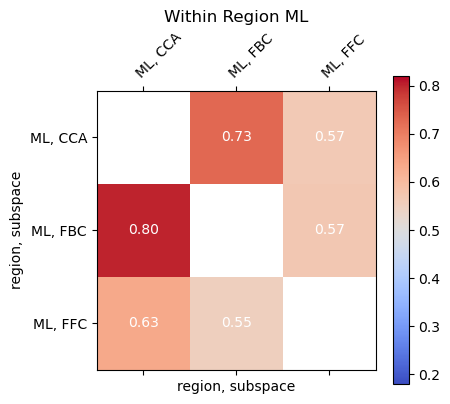